In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.chdir('..')

import pickle
import re
from pathlib import Path

import torch
import datasets
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from transformers.modeling_outputs import CausalLMOutputWithPast

from tqdm import tqdm

from model import MemoryCell

In [2]:
pd.set_option('display.max_rows', 200)

In [3]:
import pandas as pd
# df = pd.DataFrame({'text': texts})
# df.to_csv('pg19_valid_1k_chunks.csv')
texts_df = pd.read_csv('./data/pg19_valid_1k_chunks.csv', index_col=0)
texts_df.head()

,text
0,"'Let us stay here,' she exclaimed. 'The one ro..."
1,These lobsters don't realize that Jonesy's fas...
2,It certainly was not relief that he felt on di...
3,Down to 1765 the duty imposed was only one pen...
4,"And what was, perhaps, more extraordinary, tho..."


In [4]:
import json
tokens_to_bytes = json.load(open('./tokens_to_bytes.json', 'r'))

In [5]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14           # Base font size
mpl.rcParams['axes.labelsize'] = 14      # Axis label font size
mpl.rcParams['axes.titlesize'] = 14      # Title font size
mpl.rcParams['xtick.labelsize'] = 12     # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 12     # Y-axis tick label font size
mpl.rcParams['legend.fontsize'] = 12     # Legend font size

In [6]:
models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
          'EleutherAI/pythia-2.8b',
          'allenai/OLMo-1B-0724-hf',
          'princeton-nlp/Sheared-LLaMA-1.3B',
          'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B',
          ]
N_mem_tokens = 1

data = []
from pathlib import Path
for model_name in tqdm(models):
    cfg = AutoConfig.from_pretrained(model_name)
    getattr(cfg, 'num_hidden_layers')
    load_path = Path(f'./runs/{model_name}/')
    for file_path in load_path.glob(f'mem_{N_mem_tokens}_len_*.pkl'):
        if file_path.is_file():
            # Extract max_length from the file name using regex
            match = re.search(f'mem_{N_mem_tokens}_len_(\d+)(_rnd_vocab_100k)?\.pkl', file_path.name)
            if match:
                max_length = int(match.group(1))
            else:
                continue
            
            try:
                with open(file_path, 'rb') as f:
                    d = pickle.load(f)
            except Exception as e:
                continue

        try:
            d = pickle.load(open(file_path, 'rb'))
        except:
            continue
        for el in d:
            data += [{
                'model_name': model_name,
                'max_length': el['max_length'],
                'n_mem_tokens': el['n_mem_tokens'],
                'original_loss': el['original_loss'],
                'best_loss': np.min(el['losses'][:5000]),#el['best_loss'],
                'best_accuracy': np.max(el['accuracies'][:5000]),#el['best_accuracy'],#np.max(el['accuracies'][:5000]), #
                'shuffled': el['args'].get('shuffled', False),
                'mem_dim': el['best_memory_params'].shape[-1],
                'n_layers': getattr(cfg, 'num_hidden_layers'),
                'vocab_size': getattr(cfg, 'vocab_size'),
                'n_att_heads': getattr(cfg, 'num_attention_heads'),
                'intermediate_size': getattr(cfg, 'intermediate_size'),
                'token2bytes': tokens_to_bytes.get(model_name)
            }]
all_models_df = pd.DataFrame(data)

100%|██████████| 12/12 [00:25<00:00,  2.13s/it]


/tmp/ipykernel_828721/1663763571.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))
/tmp/ipykernel_828721/1663763571.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 1, 0.95], w_pad=.00, h_pad=0.5)  # Adjust layout to accommodate legends and labels properly


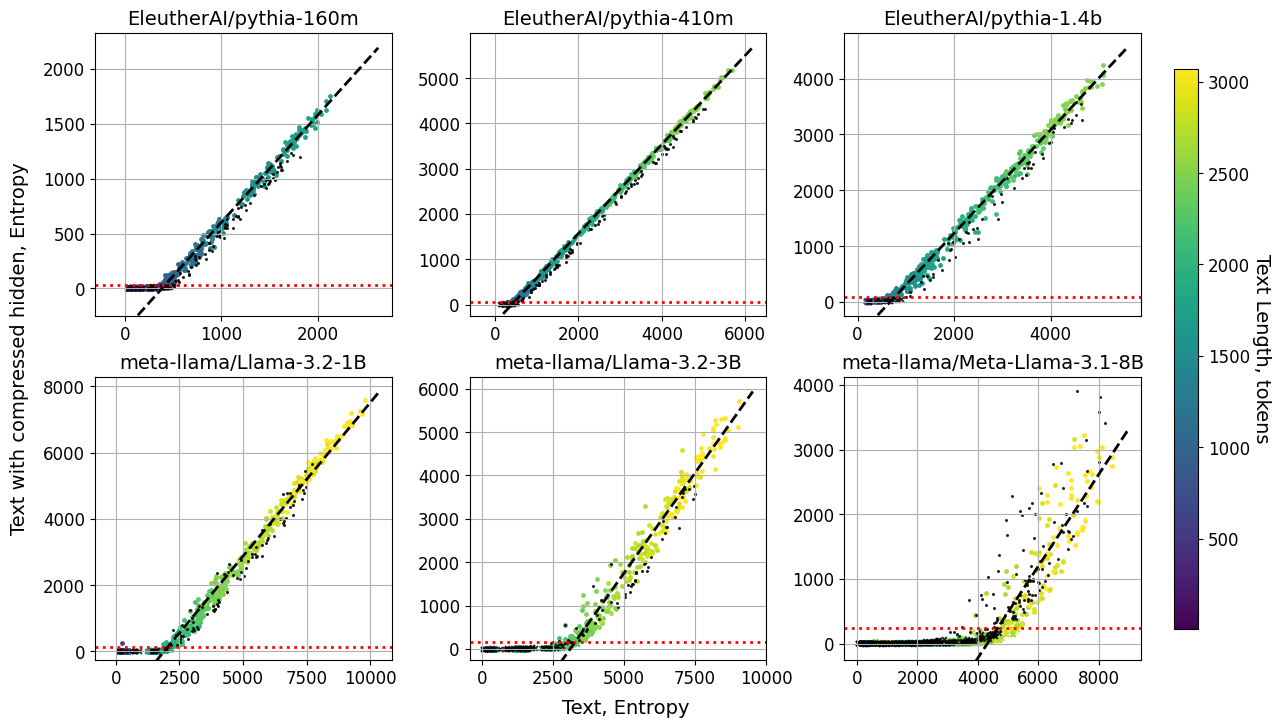

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from transformers import AutoTokenizer


# List of models
models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
          'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B']
N_mem_tokens = 1

# Create subplots for each model
n_columns = 3
n_rows = (len(models) + n_columns - 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(12, 4 * n_rows),sharey=False,sharex=False)

s = 6
acc_thr = 0.99
alpha=0.8

def polynomial(x, a, b):
    return a * x + b

# Define a global color map for max_lengths
max_lengths = sorted(all_models_df[all_models_df['shuffled']==False]['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

# Create a continuous colormap object (e.g., viridis)
cmap = plt.cm.viridis
vmin, vmax = min(max_lengths), max(max_lengths)
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

data = []
for idx, model_name in enumerate(models):

    model_df = all_models_df[all_models_df['model_name'] == model_name]
    df = model_df[model_df['shuffled'] == False]
    if len(df) == 0:
        print(f'skipping {model_name}')
        continue

    # Split data based on best_accuracy threshold
    d_below_thr = df[df['best_accuracy'] < acc_thr]
    d_above_thr = df[df['best_accuracy'] >= acc_thr]

    # Extract data for fitting
    x_data = d_below_thr['original_loss'] * d_below_thr['max_length']
    y_data = d_below_thr['best_loss'] * d_below_thr['max_length']

    # Use curve_fit to fit the polynomial function to the data
    if len(y_data) > 0:
        params, _ = curve_fit(polynomial, x_data, y_data)
        a, b = params

        # Generate values for the fitted curve
        x_fit = np.linspace(min(x_data) - 500, max(x_data) + 500, 500)
        y_fit = polynomial(x_fit, *params)

    # Define a colormap to assign consistent colors to each unique max_length
    # colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))
    # color_map = {max_length: colors(i) for i, max_length in enumerate(df['max_length'].unique())}

    ax = axes.flat[idx]

    # Plot data points, grouped by max_length
    for max_length in sorted(df['max_length'].unique()):
        subset_below = d_below_thr[d_below_thr['max_length'] == max_length]
        subset_above = d_above_thr[d_above_thr['max_length'] == max_length]

        # Plot points below the accuracy threshold
        if len(subset_below) > 0:
            ax.scatter(
                subset_below['original_loss'] * max_length, 
                subset_below['best_loss'] * max_length,
                # label=f'length={max_length}',
                s=s,
                color=global_color_map[max_length]
            )

        # Plot points above the accuracy threshold
        if len(subset_above) > 0:
            ax.scatter(
                subset_above['original_loss'] * max_length, 
                subset_above['best_loss'] * max_length,
                color=global_color_map[max_length],  # Use the same color as for the points below the threshold
                marker='x', 
                s=s * 2,
                # label=f'length={max_length}, accuracy>={acc_thr}'
            )

    # Highlight points where shuffled is True
    shuffled_df = model_df[model_df['shuffled'] == True]
    # take only at max 10 points from random texts per length
    # shuffled_df = shuffled_df.groupby('max_length').apply(lambda x: x.sample(min(25, len(x))), include_groups=False).reset_index(drop=False, level=0)
    if len(shuffled_df) > 0:
        shuffled_df = shuffled_df[shuffled_df['original_loss'] * shuffled_df['max_length'] <= max(x_data)]
        d_below_thr_shuffled = shuffled_df[shuffled_df['best_accuracy'] < acc_thr]
        d_above_thr_shuffled = shuffled_df[shuffled_df['best_accuracy'] >= acc_thr]

        if len(d_below_thr_shuffled) > 0:
            ax.scatter(
                d_below_thr_shuffled['original_loss'] * d_below_thr_shuffled['max_length'],
                d_below_thr_shuffled['best_loss'] * d_below_thr_shuffled['max_length'],
                color='black',
                marker='.',
                s=s,
                alpha=alpha,
                label='random text'
            )
        if len(d_above_thr_shuffled) > 0:
            ax.scatter(
                d_above_thr_shuffled['original_loss'] * d_above_thr_shuffled['max_length'],
                d_above_thr_shuffled['best_loss'] * d_above_thr_shuffled['max_length'],
                color='black',
                marker='x',
                s=s * 2,
                alpha=alpha,
                label=f'random text, accuracy>={acc_thr}'
            )

    # Plot the fitted curve with formula in the legend
    if len(y_data) > 0:
        formula_label = f'Fitted line: y = {a:.2f}x + {b:.1f}'
        ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=formula_label)

    # Find the value of best_loss corresponding to the accuracy threshold
    best_loss_thr = (d_above_thr['best_loss'] * d_above_thr['max_length']).max()

    # Add a horizontal line for the best_loss threshold
    ax.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'loss threshold for accuracy >= {acc_thr}')

    # Labels, legend, and grid for each subplot
    # ax.set_xlabel('Text, Entropy')
    ax.set_title(f'{model_name}')
    ax.grid()

    # Move the legend outside of the plot for each subplot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # if idx == 0:
        # ax.legend(loc='upper left', frameon=True, fancybox=True, framealpha=0.7)
    
    ax.set_ylim(-250, None)

# Set common ylabel for all subplots
# axes[0,0].set_ylabel('Text loss with compressed hidden * length')

# Remove any empty subplots if there are fewer models than subplots
for idx in range(len(models), n_rows * n_columns):
    fig.delaxes(axes.flat[idx])

# Set common ylabel for all subplots
fig.text(0.04, 0.5, 'Text with compressed hidden, Entropy', va='center', rotation='vertical')
fig.text(0.5, 0.05, 'Text, Entropy', va='center', rotation='horizontal')


fig.subplots_adjust(right=0.85)

# 4) Create a new axes for the colorbar outside the main figure area
#    (x-position=0.87, y-position=0.15, width=0.02, height=0.7).
cax = fig.add_axes([1.01, 0.15, 0.02, 0.7])

# 5) Create a ScalarMappable to link the colormap and normalization
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # For older Matplotlib compatibility

# 6) Draw the colorbar in the new axes
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Text Length, tokens", rotation=270, labelpad=15)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95], w_pad=.00, h_pad=0.5)  # Adjust layout to accommodate legends and labels properly
plt.savefig("notebooks/imgs/entropy_vs_compressed_entropy.pdf", format='pdf', bbox_inches='tight')
plt.show()